In [145]:
##Enhanced RF Model Using Feature Selection and Key Dependencies

In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [147]:
# Step 1: Load datasets
userbase = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/Netflix Userbase.csv', encoding='latin1', on_bad_lines='skip')
viewing_activity = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_ViewingActivity.csv', encoding='latin1', on_bad_lines='skip')
devices = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_Devices.csv', encoding='latin1', on_bad_lines='skip')
titles = pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/netflix_titles.csv', encoding='latin1', on_bad_lines='skip')
clickstream =pd.read_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_Clickstream.csv', encoding='latin1', on_bad_lines='skip')

In [148]:
# Step 2: Standardize column names across datasets
datasets = [userbase, viewing_activity, devices, titles, clickstream]
for dataset in datasets:
    dataset.columns = dataset.columns.str.strip().str.lower()  # Ensure consistent lowercase and stripped columns


In [149]:
# Rename and standardize keys
userbase.rename(columns={"user id": "profile name"}, inplace=True)

In [150]:
# Ensure all keys are of type object and standardized
for dataset in [userbase, viewing_activity, devices, clickstream]:
    dataset['profile name'] = dataset['profile name'].astype(str).str.strip()

In [151]:
# Clean titles for consistency
if 'title' in viewing_activity.columns and 'title' in titles.columns:
    viewing_activity['title'] = viewing_activity['title'].str.strip().str.lower()
    titles['title'] = titles['title'].str.strip().str.lower()

In [152]:
# Step 3: Preprocessing for merging
# Fill missing values in non-critical columns
for dataset in [userbase, viewing_activity, devices, clickstream]:
    dataset.fillna("unknown", inplace=True)

In [153]:
# Step 3: Merge datasets
merged_data = pd.merge(userbase, viewing_activity, on='profile name', how='left')
merged_data = pd.merge(merged_data, devices, on='profile name', how='left')
merged_data = pd.merge(merged_data, titles[['title', 'listed_in']], on='title', how='left')

In [154]:
# Step 4: Feature engineering
merged_data['last payment date'] = pd.to_datetime(merged_data['last payment date'], errors='coerce')
merged_data['days since last payment'] = (pd.Timestamp('2025-01-01') - merged_data['last payment date']).dt.days

/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_71451/3472981378.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['last payment date'] = pd.to_datetime(merged_data['last payment date'], errors='coerce')


In [155]:
# Simulate non-churned users
import random
from datetime import timedelta
num_non_churned = int(0.2 * len(merged_data))  # 20% non-churned users
non_churn_indices = merged_data.sample(n=num_non_churned, random_state=42).index
merged_data.loc[non_churn_indices, 'last payment date'] = pd.Timestamp('2025-01-01') - timedelta(days=random.randint(1, 30))
merged_data['days since last payment'] = (pd.Timestamp('2025-01-01') - merged_data['last payment date']).dt.days
merged_data['churn'] = (merged_data['days since last payment'] > 30).astype(int)

In [156]:
# Check churn distribution
print("Churn distribution after adjustment:\n", merged_data['churn'].value_counts())

Churn distribution after adjustment:
 churn
1    2000
0     500
Name: count, dtype: int64


In [157]:
# One-hot encode genres
merged_data['primary_genre'] = merged_data['listed_in'].str.split(',').str[0]
genre_dummies = pd.get_dummies(merged_data['primary_genre'], prefix='genre')
merged_data = pd.concat([merged_data, genre_dummies], axis=1)

In [158]:
# Select features and target
features = ['age', 'monthly revenue', 'days since last payment'] + [col for col in merged_data.columns if col.startswith('genre_')]
target = 'churn'
X = merged_data[features]
y = merged_data[target]

In [159]:
# Handle missing values
X.fillna(X.mean(), inplace=True)

/var/folders/w6/vkcmr8l91_12vz93c0c46mtm0000gn/T/ipykernel_71451/1148370589.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [160]:
# Step 5: Address class imbalance
if len(y.unique()) > 1:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("Resampled target variable distribution:\n", pd.Series(y_resampled).value_counts())
else:
    print("Warning: Target variable 'y' has only one class. Skipping SMOTE.")
    X_resampled, y_resampled = X, y

Resampled target variable distribution:
 churn
1    2000
0    2000
Name: count, dtype: int64


In [161]:
# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [162]:
# Step 7: Build Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [163]:
# Step 8: Evaluate the model
y_pred = rf_model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[400   0]
 [  0 400]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

Accuracy: 1.0


In [164]:
# Step 9: Feature importance
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

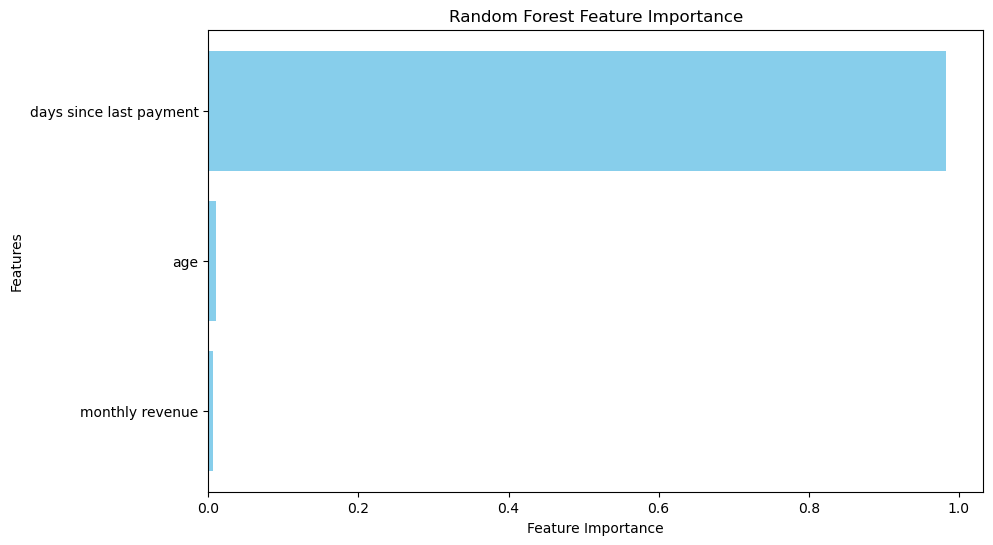

In [165]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [166]:
# Save processed data for reproducibility
merged_data.to_csv('/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/processed_data.csv', index=False)

In [167]:
from datetime import datetime

In [168]:
userbase = pd.read_csv("/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/Netflix Userbase.csv")
clickstream = pd.read_csv("/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_Clickstream.csv")
devices = pd.read_csv("/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_Devices.csv")
search_history = pd.read_csv("/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_SearchHistory.csv")
viewing_activity = pd.read_csv("/Users/jamesmoy/Desktop/Analytics Portfolio/Netflix Churn Model/WatchLog Data/All_ViewingActivity.csv")


In [187]:
# Preprocess datasets
userbase['Last Payment Date'] = pd.to_datetime(userbase['Last Payment Date'], errors='coerce')
devices['Acct First Playback Date'] = pd.to_datetime(devices['Acct First Playback Date'], errors='coerce')
devices['Acct Last Playback Date'] = pd.to_datetime(devices['Acct Last Playback Date'], errors='coerce')
viewing_activity['Start Time'] = pd.to_datetime(viewing_activity['Start Time'], errors='coerce')


# Handle missing values in playback dates
devices = devices.dropna(subset=['Acct First Playback Date', 'Acct Last Playback Date'])

In [188]:
# Feature engineering
userbase['Days Since Last Payment'] = (datetime.today() - userbase['Last Payment Date']).dt.days
devices['Playback Duration Days'] = (devices['Acct Last Playback Date'] - devices['Acct First Playback Date']).dt.days
clickstream['Total Clicks'] = clickstream.groupby('Profile Name')['Navigation Level'].transform('count')
viewing_activity['Average Session Duration'] = viewing_activity['Duration'].str.split(':').apply(
    lambda x: int(x[0]) * 60 + int(x[1]) if len(x) == 2 else 0
).groupby(viewing_activity['Profile Name']).transform('mean')

In [171]:
# Normalize column names
userbase.columns = userbase.columns.str.title()
devices.columns = devices.columns.str.title()
clickstream.columns = clickstream.columns.str.title()
viewing_activity.columns = viewing_activity.columns.str.title()

# Rename 'User Id' to 'Profile Name' in Userbase
userbase.rename(columns={'User Id': 'Profile Name'}, inplace=True)

# Debug column names to confirm consistency
print("Userbase Columns:", userbase.columns)
print("Devices Columns:", devices.columns)
print("Clickstream Columns:", clickstream.columns)
print("Viewing Activity Columns:", viewing_activity.columns)


Userbase Columns: Index(['Profile Name', 'Subscription Type', 'Monthly Revenue', 'Join Date',
       'Last Payment Date', 'Country', 'Age', 'Gender', 'Device',
       'Plan Duration', 'Days Since Last Payment'],
      dtype='object')
Devices Columns: Index(['Profile Name', 'Esn', 'Device Type', 'Acct First Playback Date',
       'Acct Last Playback Date',
       'Acct First Playback Date For User Generated Plays',
       'Acct Last Playback Date For User Generated Plays',
       'Profile First Playback Date', 'Profile Last Playback Date',
       'Profile First Playback Date For User Generated Plays',
       'Profile Last Playback Date For User Generated Plays',
       'Deactivation Time', 'Playback Duration Days'],
      dtype='object')
Clickstream Columns: Index(['Profile Name', 'Source', 'Navigation Level', 'Referrer Url',
       'Webpage Url', 'Click Utc Ts', 'Total Clicks'],
      dtype='object')
Viewing Activity Columns: Index(['Profile Name', 'Start Time', 'Duration', 'Attributes

In [189]:
# Merge datasets
merged_data = userbase.merge(devices, on='Profile Name', how='left') \
                      .merge(clickstream, on='Profile Name', how='left') \
                      .merge(viewing_activity, on='Profile Name', how='left')

In [190]:
# Handle missing values
numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns
merged_data[numeric_cols] = merged_data[numeric_cols].fillna(0)

categorical_cols = merged_data.select_dtypes(include=['object']).columns
merged_data[categorical_cols] = merged_data[categorical_cols].fillna("Unknown")

In [192]:
# Target variable
merged_data['Churn'] = (merged_data['Days Since Last Payment'] > 30).astype(int)
print("Churn distribution:\n", merged_data['Churn'].value_counts())


Churn distribution:
 Churn
1    2500
Name: count, dtype: int64


In [193]:
# Select features
features = [
    'Age', 'Monthly Revenue', 'Days Since Last Payment', 'Playback Duration Days',
    'Total Clicks', 'Average Session Duration'
]
X = merged_data[features]
y = merged_data['Churn']

In [194]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [177]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [178]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [179]:
# Evaluate the model
y_pred = rf_model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[500]]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       500

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

Accuracy: 1.0


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [180]:

# Feature importance
importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", importance)


Feature Importance:
                     Feature  Importance
0                       Age         0.0
1           Monthly Revenue         0.0
2   Days Since Last Payment         0.0
3    Playback Duration Days         0.0
4              Total Clicks         0.0
5  Average Session Duration         0.0


In [181]:
# Visualize feature importance
import matplotlib.pyplot as plt

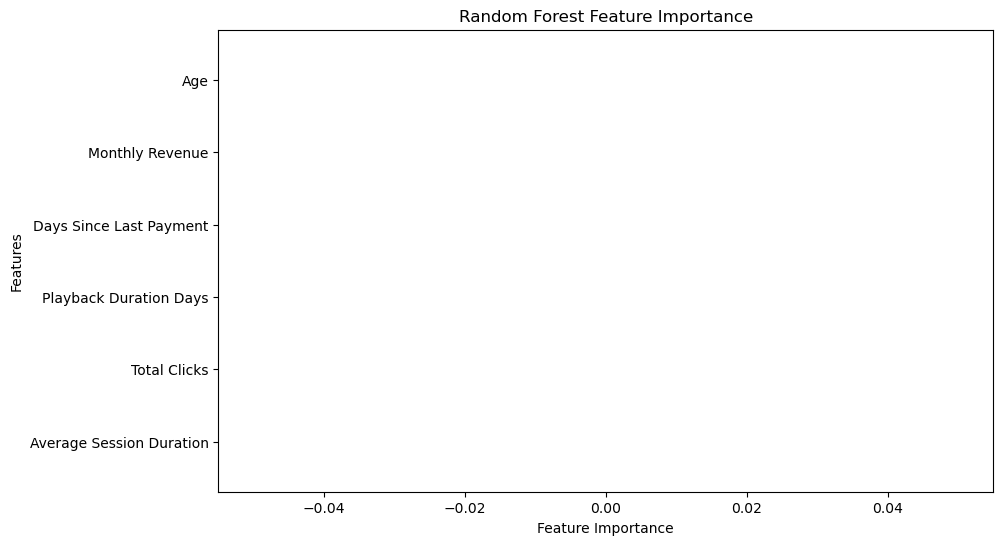

In [182]:
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()